In [73]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.patches as patches
import scipy.ndimage

%matplotlib inline

In [75]:
k = 1 # Boltzmann constant
n_cell_id = 200 # Number of cells?
n_types = 3 # Number of cell types
N = 50 # Size of grid without surrounding medium
n_steps = 100000 # Number of iterations
J = np.zeros((n_types + 1, n_types + 1)) # Cell grid?
lamb = 1 # something in Hvol, just a constant maybe
At = [0,10,10] # List where each index is the equilibrium area of a cell type

J[0,0] = 0
J[0,1] = 8
J[0,2] = 8
J[1,0] = 8
J[1,1] = 2
J[1,2] = 5
J[2,0] = J[0,2]
J[2,1] = J[1,2]
J[2,2] = J[1,1]

start_temp = 400
temp_decay = .8
# THIS SHOULD BE RANDOMIZED!!

# converts cell ID to cell type; location represents cell ID, value represents cell type
# Randomized
# Initial list such that each type is included
zero_id = np.array([0])
init_id = np.arange(1, n_types, dtype='int')
rest_id = np.random.randint(1, n_types, size=(n_cell_id-len(init_id)))

# Concatenate list and shuffle
almost_complete_id = np.concatenate([init_id, rest_id])
np.random.shuffle(almost_complete_id)

# Finalize list
id_to_type = np.concatenate([zero_id, almost_complete_id])
print(id_to_type)
# Initial grid
def initial_grid():
    # Cell size rounded down for initial grid
    cell_size = int((N**2)/n_cell_id)
    # Medium is cell type=0, start with full medium
    grid_cell_0 = np.zeros((N + 2, N + 2), dtype=int)
    # Create list with all grid points numbered from top to bottom in reading order, without sides
    coor_list = list(range(1,N**2+1))
    
    # Loop through all cell id's
    for i in range(1, n_cell_id+1):
        # Choose random number as starting point for initial cell to grow
        r_coor = np.random.choice(coor_list)
        # Convert chosen number to coordinate
        if r_coor % N == 0:
            chosen_col = N
            chosen_row = int(r_coor/N)
        else:
            chosen_col = r_coor % N
            chosen_row = int(r_coor/N) + 1
        
        # Change chosen point to cell id
        grid_cell_0[chosen_row, chosen_col] = i
        # Remove as choice
        coor_list.remove(r_coor)
        
        # Grow cell to cell size randomly
        for j in range(cell_size-1):
            choices = ["up", "down", "left", "right"]
            # Continue until all choices are tried
            # If no choices are left and its not moved, the growth of the cell stops
            while choices != []:
                move_to = np.random.choice(choices)
                # Move up
                if move_to == "up":
                    new_row = chosen_row - 1
                    # Change if it doesn't go to a side and its not another cell
                    if new_row != 0 and grid_cell_0[new_row, chosen_col] == 0:
                        grid_cell_0[new_row, chosen_col] = i
                        # Remove as choice
                        coor_list.remove(int(r_coor-N))
                        # Change to new growth spot
                        chosen_row = new_row
                        r_coor = r_coor-N
                        break
                    # Unable to move so remove option 
                    else:
                        choices.remove("up")
                        
                # Move down
                elif move_to == "down":
                    new_row = chosen_row + 1
                    # Change if it doesn't go to a side and its not another cell
                    if new_row != N+1 and grid_cell_0[new_row, chosen_col] == 0:
                        grid_cell_0[new_row, chosen_col] = i
                        # Remove as choice
                        coor_list.remove(int(r_coor+N))
                        # Change to new growth spot
                        chosen_row = new_row
                        r_coor = r_coor+N
                        break
                    # Unable to move so remove option 
                    else:
                        choices.remove("down")
                        
                # Move down
                elif move_to == "left":
                    new_col = chosen_col - 1
                    # Change if it doesn't go to a side and its not another cell
                    if new_col != 0 and grid_cell_0[chosen_row, new_col] == 0:
                        grid_cell_0[chosen_row, new_col] = i
                        # Remove as choice
                        coor_list.remove(int(r_coor-1))
                        # Change to new growth spot
                        chosen_col = new_col
                        r_coor = r_coor-1
                        break
                    # Unable to move so remove option 
                    else:
                        choices.remove("left")
                
                # Move down
                elif move_to == "right":
                    new_col = chosen_col + 1
                    # Change if it doesn't go to a side and its not another cell
                    if new_col != N+1 and grid_cell_0[chosen_row, new_col] == 0:
                        grid_cell_0[chosen_row, new_col] = i
                        # Remove as choice
                        coor_list.remove(int(r_coor+1))
                        # Change to new growth spot
                        chosen_col = new_col
                        r_coor = r_coor+1
                        break
                    # Unable to move so remove option 
                    else:
                        choices.remove("right")
                        
    return grid_cell_0


def cellular_potts_model(J, At, lamb,start_temp, temp_decay):
    T = start_temp
    init_grid = initial_grid()
    grid = init_grid.copy()
    
    plt.figure()
    plt.imshow(grid)
    plt.title('Initial grid') # Just to indentify the plot in output
    
    H_value = 0
    # List to save hamiltonian values each step?
    H = np.zeros(int(n_steps/10)+1)
    N_CELLS = np.zeros(int(n_steps/10)+1)
    A_MIN = np.zeros(int(n_steps/10)+1)
    A_MAX = np.zeros(int(n_steps/10)+1)
    A_MEAN = np.zeros(int(n_steps/10)+1)
    BORD_LENGTH = np.zeros(int(n_steps/10)+1)
    # Initial hamiltonian of grid
    H_change, N_cells,a_min,a_max,a_mean,border_length = get_hamiltonian(J, At, lamb, grid)
    print(H_change)        
    
    for step in range(n_steps+1):
        #print(step)
        H_value += H_change
        if step % 10 == 0:
            H[int(step/10)] = H_value
            N_CELLS[int(step/10)] = N_cells
            A_MIN[int(step/10)] = a_min
            A_MAX[int(step/10)] = a_max
            A_MEAN[int(step/10)] = a_mean
            BORD_LENGTH[int(step/10)] = border_length
        # Choose random lattice side
        i,j = np.random.randint(1,N+1,2)
        # Choose random neighbour (Moore)
        new_id = grid[i + np.random.randint(-1,2)][j + np.random.randint(-1,2)]
        
        # Calculate hamiltonian of grid if lattice side was changed to neighbour
        temp_grid = grid.copy()
        temp_grid[i][j] = new_id
        H_pos, N_cells_pos, a_min_pos, a_max_pos, a_mean_pos, bord_length_pos = get_hamiltonian(J, At, lamb, temp_grid)
        
        # Apply metropolis step
        H_change = H_pos - H_value
        if H_change <= 0:
            grid[i][j] = new_id
            N_cells = N_cells_pos
            a_min = a_min_pos
            a_max = a_max_pos
            a_mean = a_mean_pos
            border_length = bord_length_pos
        else:
            P = np.exp(-H_change/(k * T))
            if P > np.random.uniform():
                grid[i][j] = new_id
                N_cells = N_cells_pos
                a_min = a_min_pos
                a_max = a_max_pos
                a_mean = a_mean_pos
                border_length = bord_length_pos
            else:
                H_change = 0
            # Lower temperature for simulated annealing
            T = temp_decay * T
        
        # Show progression of grid each 1000 steps
        if step % 5000 == 0:
            print(step)
            #plt.figure()
            #plt.imshow(grid)
            #plt.title('Grid at t=%d' % step) # Just to indentify the plot in output
        
            
    
    # Plot final grid
    plot_potts_model(grid, id_to_type, H)
    return H, N_CELLS, A_MIN, A_MAX, A_MEAN,BORD_LENGTH, id_to_type, init_grid,grid
        
        
def get_hamiltonian(J, At, lamb, grid):
    H_vol = 0
    # Exlude 0 which is the medium
    N_CELLS = 0
    areas = np.zeros(n_cell_id)
    for i in range(1, n_cell_id + 1):
        a = np.count_nonzero(grid == i)
        if a:
            N_CELLS += 1
        areas[i-1] = a
        H_vol += (a - At[id_to_type[i]])**2
    H_vol *= lamb
    H_bond, border_length = get_H_bond(J, grid, id_to_type)
    
    return H_vol + H_bond, N_CELLS, np.min(areas), np.max(areas), np.mean(areas), border_length

@njit(parallel = True)
def get_H_bond(J, grid, id_to_type):
    H_bond = np.zeros(N)
    border_length = np.zeros(N)
    for i in prange(1, N + 1):
        H_bond_i = 0
        bord_i = 0
        for j in range(1, N+1):
            sigm = grid[i][j]
            type_s =  id_to_type[sigm]
            for k in [-1,0,1]:
                for l in [-1,0,1]:
                    sigm_neighbour = grid[i + k][j + l]
                    if not sigm == sigm_neighbour:
                        J_add = J[type_s,id_to_type[sigm_neighbour]]
                        H_bond_i += J_add
                        bord_i += 1
        H_bond[i-1] = H_bond_i
        border_length[i-1] = bord_i
    return np.sum(H_bond), np.sum(border_length)/2

def plot_potts_model(grid, id_to_type, H):
    
    fig = plt.figure(facecolor='w', figsize=(12,4), dpi=80)
 
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax.plot( H , 'brown')
    ax.grid(b=True, which='major', c='k', alpha=0.2)
    ax.set_xlabel('n')
    ax.set_ylabel('H')
    #ax.set_title('Magnetization modulus for J = %d' % J)
    
    ax = plt.subplot2grid((1, 3), (0, 2))
    ax.matshow(id_to_type[grid[1:-1, 1:-1]], cmap = 'hot')
    
    
#     highres_bord = scipy.ndimage.zoom(grid[1:-1, 1:-1], 20, order=0, mode='nearest') 
#     highres_type = scipy.ndimage.zoom(id_to_type[grid[1:-1, 1:-1]], 20, order=0, mode= 'nearest')
    
#     ax.imshow(highres_type, cmap = 'hot')
#     ax.contour(highres_bord, levels = [i for i in range(n_cell_id + 1)], colors = 'blue', linewidths = .2)

#     ax.set_title('n = %i' % n_steps)
#     ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    

[0 2 1 2 1 2 1 2 1 2 2 2 2 2 1 2 2 1 1 2 1 1 2 1 2 2 1 2 2 1 2 2 2 2 1 1 2
 2 2 2 1 1 1 2 2 2 2 2 1 1 2 2 2 2 2 2 2 1 1 1 1 1 2 1 2 1 2 1 1 1 1 1 1 2
 2 1 1 2 1 2 2 1 2 1 1 1 1 1 1 2 1 2 2 1 1 2 2 1 1 1 1 2 2 1 1 2 1 1 1 1 1
 2 1 2 2 2 1 1 1 2 1 1 1 1 1 2 1 2 1 1 2 1 1 1 2 1 2 2 1 1 1 2 1 2 2 1 2 2
 2 1 2 1 1 1 2 1 1 2 2 1 1 1 2 1 1 1 1 2 2 1 2 2 2 1 2 2 2 2 1 2 2 1 2 1 1
 2 2 1 1 1 1 1 1 1 2 1 2 1 2 1 1]


0
66777.0
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000


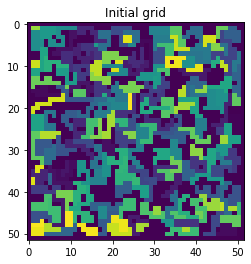

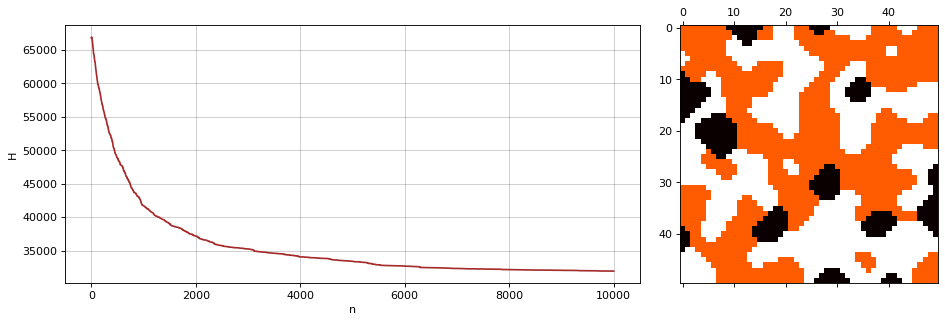

1
66788.0
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000


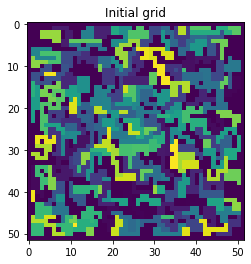

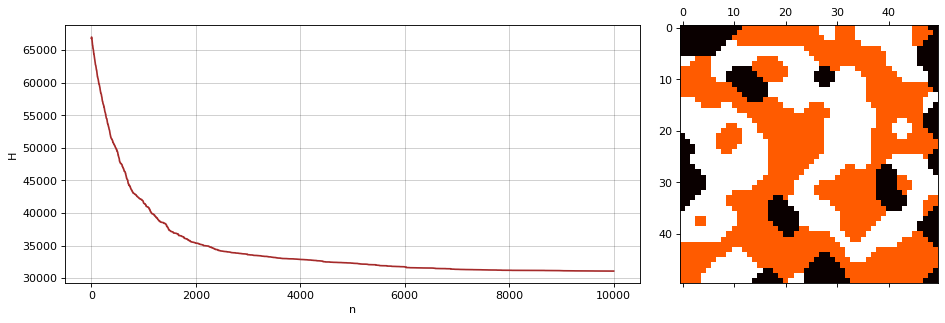

2
65404.0
0
5000
10000
15000


KeyboardInterrupt: 

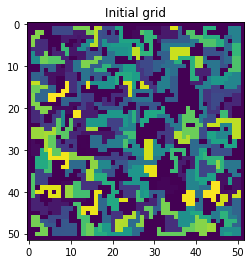

In [76]:
version = 4
#H, N_CELLS, A_MIN, A_MAX, A_MEAN,BORD_LENGTH, id_to_type, init_grid,grid
for i in range(10):
    print(i)
    VALUES = cellular_potts_model(J, At, lamb,start_temp, temp_decay)
    np.save('H_V{}_{}.npy'.format(version,i),VALUES[0])
    np.save('N_CELLS_V{}_{}.npy'.format(version,i), VALUES[1])
    np.save('A_MIN_V{}_{}.npy'.format(version,i), VALUES[2])
    np.save('A_MAX_V{}_{}.npy'.format(version,i), VALUES[3])
    np.save('A_MEAN_V{}_{}.npy'.format(version,i), VALUES[4])
    np.save('BORD_LENGTH_V{}_{}.npy'.format(version,i), VALUES[5])
    np.save('ID_TO_TYPE_V{}_{}.npy'.format(version,i), VALUES[6])
    np.save('INIT_GRID_V{}_{}.npy'.format(version,i), VALUES[7])
    np.save('FINAL_GRID_V{}_{}.npy'.format(version,i), VALUES[8])

[(array([66958., 66958., 66958., ..., 18104., 18104., 18104.]), array([100., 100., 100., ...,   0.,   0.,   0.]), array([ 1.,  1.,  1., ..., 21., 21., 21.]), array([25., 25., 26., ..., 26., 26., 26.]), array([17.14, 17.13, 17.12, ..., 23.44, 23.44, 23.44]), array([4592.5, 4590.5, 4591.5, ..., 2958. , 2958. , 2958. ]), array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,  52,  52, ...,   0,   0,   0],
       [  0,  52,  52, ...,   0,   0,   0],
       ...,
       [  0, 100,   1, ...,  31,  31,   0],
       [  0, 100,   1, ...,  31,  31,   0],
       [  0,   0,   0, ...,   0,   0,   0]]), array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,  52, 

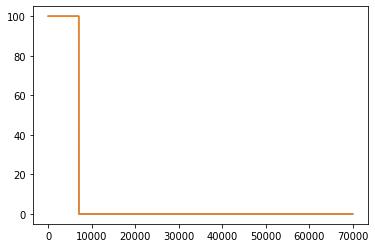